# Лабораторная работа №1

In [11]:
import matplotlib 
matplotlib.use('notebook')
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np

## Подготовка данных

In [12]:
# Download dataset
# https://www.kaggle.com/datasets/hojjatk/mnist-dataset
import kagglehub

dataset_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

### Загрузка данных

In [13]:
# https://www.kaggle.com/code/hojjatk/read-mnist-dataset
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import struct
from array import array
from os.path import join


#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(
        self,
        training_images_filepath,
        training_labels_filepath,
        test_images_filepath,
        test_labels_filepath,
    ):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, "rb") as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(
                    "Magic number mismatch, expected 2049, got {}".format(magic)
                )
            labels = array("B", file.read())

        with open(images_filepath, "rb") as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(
                    "Magic number mismatch, expected 2051, got {}".format(magic)
                )
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols : (i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return np.array(images), np.array(labels)

    def load_data(self):
        x_train, y_train = self.read_images_labels(
            self.training_images_filepath, self.training_labels_filepath
        )
        x_test, y_test = self.read_images_labels(
            self.test_images_filepath, self.test_labels_filepath
        )

        # Reshape images
        x_train = x_train.reshape(60000, 784)
        x_test = x_test.reshape(10000, 784)

        return (x_train, y_train), (x_test, y_test)

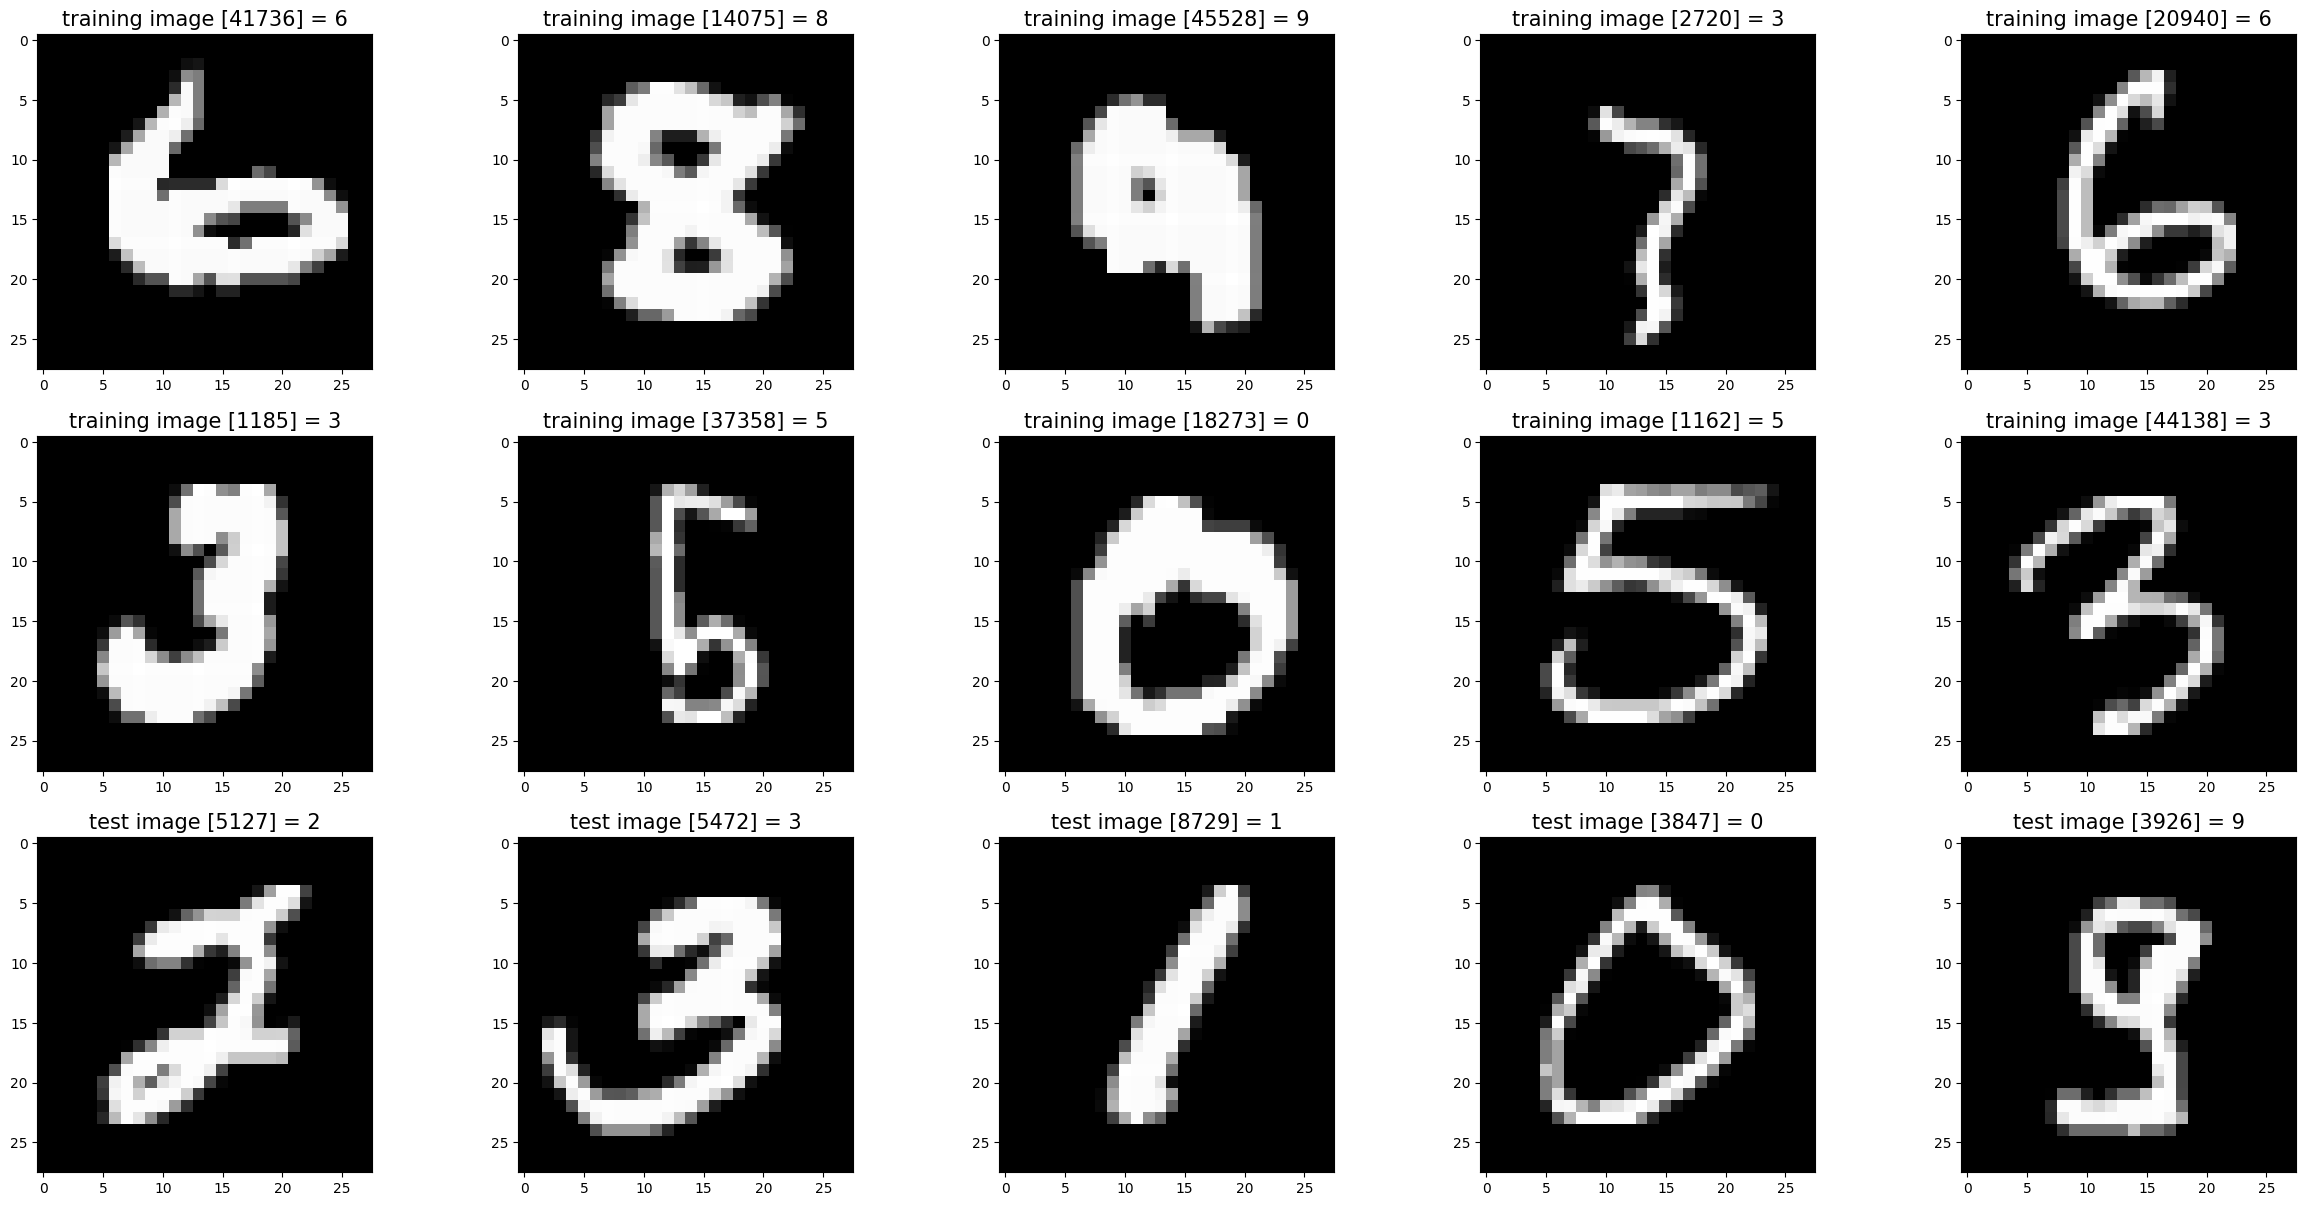

In [14]:
#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = join(
    dataset_path, "train-images-idx3-ubyte/train-images-idx3-ubyte"
)
training_labels_filepath = join(
    dataset_path, "train-labels-idx1-ubyte/train-labels-idx1-ubyte"
)
test_images_filepath = join(
    dataset_path, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
)
test_labels_filepath = join(
    dataset_path, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"
)


#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image.reshape(28, 28), cmap=plt.cm.gray)
        if title_text != "":
            plt.title(title_text, fontsize=15)
        index += 1


#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(
    training_images_filepath,
    training_labels_filepath,
    test_images_filepath,
    test_labels_filepath,
)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

#
# Show some np.random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = np.random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append("training image [" + str(r) + "] = " + str(y_train[r]))

for i in range(0, 5):
    r = np.random.randint(1, 10000)
    images_2_show.append(X_test[r])
    titles_2_show.append("test image [" + str(r) + "] = " + str(y_test[r]))

show_images(images_2_show, titles_2_show)

## Реализация нейросети

### Предобработка данных

In [15]:
def one_hot_encode(labels):
    classes = np.unique(labels)
    one_hot = np.zeros((labels.size, len(classes)), dtype=np.float64)
    one_hot[np.arange(len(labels)), labels] = 1.0
    return one_hot


# normalize the data
X_train = np.array(X_train, dtype=np.float64) / 255.0
X_test = np.array(X_test, dtype=np.float64) / 255.0

y_train = one_hot_encode(np.array(y_train, dtype=int))
y_test = one_hot_encode(np.array(y_test, dtype=int))

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [16]:
def relu(x):
    return np.maximum(0, x)


def drelu(x):
    return np.where(x > 0, 1, 0)


def softmax(x):
    exp_shifted = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=-1, keepdims=True)


def cross_entropy_loss(outputs, targets):
    outputs = np.clip(outputs, 1e-12, 1.0 - 1e-12)
    return -np.sum(targets * np.log(outputs + 1e-9)) / targets.shape[0]


def unisonShuffleDataset(x, y):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    return x[p], y[p]

In [17]:
class FullCNN:
    def __init__(self, input_size: int, output_size: int, hidden_size: int):
        # Xavier initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

    def forward_propagation(self, x):
        Z1 = np.dot(x, self.W1) + self.b1
        A1 = relu(Z1)
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = softmax(Z2)
        return Z1, A1, Z2, A2

    def backward_propagation(self, inputs, target, Z1, A1, Z2, A2):
        dZ2 = A2 - target # (64, 10)
        dZ2 = dZ2 / target.shape[0] # decrease gradient values
        dW2 = (A1.T).dot(dZ2) # (300, 10)
        db2 = np.sum(dZ2, axis=0, keepdims=True) # (1, 10)
        dA1 = dZ2.dot(self.W2.T) # (64, 300)
        dZ1 = dA1 * drelu(Z1) # (64, 300)
        dW1 = (inputs.T).dot(dZ1) # (784, 300)
        db1 = np.sum(dZ1, axis=0, keepdims=True) # (1, 300)
        return dW1, db1, dW2, db2

    def update_parameters(self, dW1, db1, dW2, db2, learning_rate):
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def __str__(self):
        return f"FullCNN: \n W1={self.W1} \n b1={self.b1} \n W2={self.W2} \n b2={self.b2}"

### Обучение

In [18]:
from time import time


def train(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size,
    epochs,
    learning_rate,
):
    start_time = time()
    for epoch in range(epochs):
        # shuffle data
        unisonShuffleDataset(X_train, y_train)
        train_loss = 0
        epoch_start = time()
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]
            Z1, A1, Z2, A2 = FullCNN.forward_propagation(model, X_batch)

            loss = cross_entropy_loss(y_batch, A2)
            train_loss += loss

            dW1, db1, dW2, db2 = model.backward_propagation(
                X_batch, y_batch, Z1, A1, Z2, A2
            )
            model.update_parameters(dW1, db1, dW2, db2, learning_rate)

        Z1_train, A1_train, Z2_train, A2_train = model.forward_propagation(X_train)
        train_accuracy = np.mean(
            np.argmax(A2_train, axis=1) == np.argmax(y_train, axis=1)
        )
        epoch_end = time()
        n_batches = X_train.shape[0] // batch_size + 1
        print(
            f"Epoch {epoch+1}/{epochs}: accuracy={train_accuracy:.4f}, loss={(train_loss / n_batches):.3f}, time={epoch_end - epoch_start:.3f} sec."
        )
    end_time = time()

    Z1_test, A1_test, Z2_test, A2_test = model.forward_propagation(X_test)
    accuracy = np.mean(np.argmax(A2_test, axis=1) == np.argmax(y_test, axis=1))
    print("------------------")
    print(
        f"Epochs = {epochs}, test accuracy = {accuracy:.4f}, full time = {end_time - start_time:.3f} sec."
    )

In [19]:
input_size = 28 * 28
output_size = 10
hidden_size = 300
batch_size = 64
epochs = 20
learning_rate = 0.1

model = FullCNN(input_size, output_size, hidden_size)
train(model, X_train, y_train, X_test, y_test, batch_size, epochs, learning_rate)

Epoch 1/20: accuracy=0.9353, loss=3.858, time=2.761 sec.
Epoch 2/20: accuracy=0.9545, loss=2.042, time=1.250 sec.
Epoch 3/20: accuracy=0.9658, loss=1.554, time=1.443 sec.
Epoch 4/20: accuracy=0.9728, loss=1.270, time=1.868 sec.
Epoch 5/20: accuracy=0.9770, loss=1.079, time=1.228 sec.
Epoch 6/20: accuracy=0.9801, loss=0.941, time=2.204 sec.
Epoch 7/20: accuracy=0.9827, loss=0.833, time=2.417 sec.
Epoch 8/20: accuracy=0.9850, loss=0.746, time=1.488 sec.
Epoch 9/20: accuracy=0.9868, loss=0.675, time=2.330 sec.
Epoch 10/20: accuracy=0.9883, loss=0.615, time=2.188 sec.
Epoch 11/20: accuracy=0.9897, loss=0.563, time=2.689 sec.
Epoch 12/20: accuracy=0.9906, loss=0.518, time=1.323 sec.
Epoch 13/20: accuracy=0.9919, loss=0.478, time=2.048 sec.
Epoch 14/20: accuracy=0.9928, loss=0.443, time=1.384 sec.
Epoch 15/20: accuracy=0.9932, loss=0.411, time=2.412 sec.
Epoch 16/20: accuracy=0.9939, loss=0.382, time=1.443 sec.
Epoch 17/20: accuracy=0.9946, loss=0.356, time=1.924 sec.
Epoch 18/20: accuracy=0

In [21]:
# str(model)